<a href="https://colab.research.google.com/github/Rob685/coolstarsucsd/blob/master/keras_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
from collections import Counter
from itertools import combinations
%tensorflow_version 2.x

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.metrics as k_metrics
from keras import optimizers

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from matplotlib.colors import LogNorm
from astropy.table import Table
import pickle

import IPython

from google.colab import drive #to import my own module, I must first follow this procedure:
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
plt.rcParams['figure.facecolor'] = 'white'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=7)

In [3]:
!pip install -U keras-tuner
import kerastuner as kt

! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng
! sudo apt-get install cm-super
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended 
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

     |████████████████████████████████| 61kB 2.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=d25a9009763d89647a004541825a9e20d29d0519fd0664255e4bd721ba810e19
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=52966beb0dc7fb28e149c8531dee8df0776b82f92d028f94a36032e017a4f558
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1


In [4]:
# Combination function:
def ccombinator(x):
    mags = pd.DataFrame(index=x.index)
    for a, b, in combinations(x.columns, 2):
        mags['{}-{}'.format(a, b)] = x[a] - x[b]
    c = mags
    return c

# DES

## DES Data Prep

Define features and targets for Keras training

In [ ]:
path_des = 'gdrive/My Drive/Colab Notebooks/des_workspace/'
des_tset = pd.read_csv(path_des+'/des_dered_data/des_tset_rob_cuts_dered_allgiants.csv',low_memory=False)

print('Training set shape:',des_tset.shape)
print(Counter(des_tset['label']))

Training set shape: (63407, 142)
Counter({'lm*': 62070, 'hm*': 1132, 'gal': 195, 'qso': 10})


In [ ]:
feature_list = ['IMAG_DERED','ZMAG_DERED',
                'YMAG_DERED',
                'w1mpro','w2mpro'
                ]
label = ['label']
tmags = des_tset[feature_list + label]
tmags2 = tmags.dropna(how='any')
tmags3 = tmags2[feature_list]

train_features = pd.concat([ccombinator(tmags3),tmags3],axis=1)

ytarget = tmags2['label']
print('Size of training features:',train_features.shape)
train_colors = train_features.drop(feature_list,axis=1)
print('Size of training colors:',train_colors.shape)

print('True composition of the training set:',Counter(ytarget))

Size of training features: (63407, 15)
Size of training colors: (63407, 10)
True composition of the training set: Counter({'lm*': 62070, 'hm*': 1132, 'gal': 195, 'qso': 10})


In [ ]:
# getting integer identifier for each class:
int_labels = []
for label in ytarget:
  if label == 'lm*':
    int_labels.append(0)
  if label == 'hm*':
    int_labels.append(1)
  if label == 'gal':
    int_labels.append(2)
  if label == 'qso':
    int_labels.append(3)

seed=42
# splitting data into train and validation set:
X_train, X_test, y_train, y_test = train_test_split(train_colors, int_labels, 
                                                    test_size=0.50,
                                                    shuffle=True,
                                                    random_state=seed)

weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights_des = {0: weights[0], 1: weights[1], 2: weights[2], 3: weights[3]}
class_weights_des

{0: 0.2553974801018271,
 1: 13.832024432809773,
 2: 90.0653409090909,
 3: 880.6388888888889}

In [ ]:
weights_list = []
for label in y_train:
  if label == 0:
    weights_list.append(weights[0])
  elif label == 1:
    weights_list.append(weights[1])
  elif label == 2:
    weights_list.append(weights[2])
  else:
    weights_list.append(weights[3])
np.shape(weights_list)

(31703,)

In [ ]:
multi_label = []
for label in ytarget:
  if label == 'lm*':
    multi_label.append([1,0,0,0])
  elif label == 'hm*':
    multi_label.append([0,1,0,0])
  elif label == 'gal':
    multi_label.append([0,0,1,0])
  else:
    multi_label.append([0,0,0,1])
np.shape(multi_label)

seed=42
# splitting data into train and validation set:
X_train, X_test, y_train, y_test = train_test_split(train_colors, multi_label, 
                                                    test_size=0.50,
                                                    shuffle=True,
                                                    random_state=seed)

np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test)

((31703, 10), (31703, 4), (31704, 10), (31704, 4))

In [ ]:
d,h,g,q = np.bincount(int_labels)
total = np.sum([d,h,g,q])
print('Examples:\n    Total: {}\n    QSOs: {} ({:.2f}% of total)\n'.format(
    total, q, 100 * q / total))

Examples:
    Total: 63407
    QSOs: 10 (0.02% of total)



## DES Training

In [ ]:
METRICS = [
      k_metrics.Precision(name='precision'),
      k_metrics.Recall(name='recall'),
      k_metrics.AUC(name='auc'),
      k_metrics.CategoricalAccuracy(name='accuracy')
]

def model_builder(hp):
  model = keras.Sequential()
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  
  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1,1e-2, 1e-3, 1e-4])
  # activation layer:
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu',input_dim=X_train.shape[1]))

  for i in range(hp.Int('num_layers', min_value = 2, max_value = 6,step=2)):
    model.add(keras.layers.Dense(units=hp_units, activation='relu')) # hidden layers
  model.add(Dense(4,activation='softmax')) # output layer

  model.compile(loss='categorical_crossentropy'
                      ,optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
                      ,metrics=METRICS # metrics
                      ,loss_weights=weights_list
                      #,weighted_metrics=METRICS
                )
   
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 200,
                     factor = 3,
                     directory = 'gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/',
                     project_name = 'DES_tuning_5_weighted') # chose 5 for 200 epoch version, and 6 for 600 epoch version. Highest number for newest version. 80_20 for 80/20 train/test ratio. 50/50 otherwise

INFO:tensorflow:Reloading Oracle from existing project gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/DES_tuning_5_weighted/oracle.json
INFO:tensorflow:Reloading Tuner from gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/DES_tuning_5_weighted/tuner0.json


In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(np.array(X_train), np.array(y_train), epochs = 200, validation_data = (np.array(X_test), np.array(y_test)), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 3)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The best number of layers is {best_hps.get('num_layers')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.0001. The best number of layers is 6.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
baseline_history = model.fit(np.array(X_train), np.array(y_train), epochs = 200, validation_data = (np.array(X_test), np.array(y_test)), 
                             #class_weight=class_weights_des,
                             batch_size=500,verbose=1)

Epoch 1/200
64/64 [==============================] - 2s 27ms/step - loss: 0.0800 - precision: 0.9895 - recall: 0.9124 - auc: 0.9965 - accuracy: 0.9810 - val_loss: 0.0283 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9960 - val_accuracy: 0.9792
Epoch 2/200
64/64 [==============================] - 1s 20ms/step - loss: 0.0261 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - accuracy: 0.9786 - val_loss: 0.0210 - val_precision: 0.9794 - val_recall: 0.9792 - val_auc: 0.9965 - val_accuracy: 0.9792
Epoch 3/200
64/64 [==============================] - 1s 20ms/step - loss: 0.0147 - precision: 0.9924 - recall: 0.9907 - auc: 0.9970 - accuracy: 0.9915 - val_loss: 0.0127 - val_precision: 0.9951 - val_recall: 0.9950 - val_auc: 0.9973 - val_accuracy: 0.9950
Epoch 4/200
64/64 [==============================] - 1s 20ms/step - loss: 0.0115 - precision: 0.9952 - recall: 0.9952 - auc: 0.9971 - accuracy: 0.9952 - val_loss: 0.0109 - val_precision: 0.9952 - val_recall: 0.9952 - val_auc: 0.9965

In [ ]:
  # version 2 was with 200 epochs. No good results for DES. Version 3 is with 600 epochs
  model.save('gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/des_tuned_model_loss_weighted.h5')
  f = open('gdrive/My Drive/Colab Notebooks/ml_preds/keras_des_histories/des_tuned_history_loss_weighted.pckl', 'wb')
  pickle.dump(baseline_history.history, f)
  f.close()

## Plotting metrics

In [5]:
baseline_history_weighted = pd.read_pickle(r'gdrive/My Drive/Colab Notebooks/ml_preds/keras_des_histories/des_tuned_history_weighted_new.pckl')
baseline_history_unweighted = pd.read_pickle(r'gdrive/My Drive/Colab Notebooks/ml_preds/keras_des_histories/des_tuned_history_unweighted.pckl')
baseline_history_loss_weighted = pd.read_pickle(r'gdrive/My Drive/Colab Notebooks/ml_preds/keras_des_histories/des_tuned_history_loss_weighted.pckl')

In [ ]:
def plot_metrics(history1,history2):
  metrics =  ['loss', 'accuracy', 'precision', 'recall']
  epochs = range(len(history1['accuracy']))
  fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
  plt.subplots_adjust(hspace=0.0)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(epochs,  history2[metric], color=colors[0], lw=1,label='train\_unweighted')
    plt.plot(epochs, history2['val_'+metric],
             color=colors[1], linestyle="--", lw=1, label='val\_unweighted')
    plt.plot(epochs,  history1[metric], color=colors[2], lw=1,label='train\_weighted')
    plt.plot(epochs, history1['val_'+metric],
             color=colors[3], linestyle="--", lw=1,label='val\_weighted')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.minorticks_on()
    if metric == 'loss':
      plt.legend()
    else:
     plt.ylim([0.996,1])
    plt.yscale('log')
  plt.minorticks_on()
  plt.tight_layout()
  plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_training_metric_plots_new_weighted.pdf',dpi=300,bbox_inches='tight',padding=0)
  plt.show()

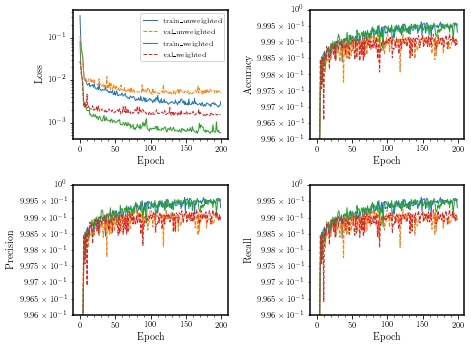

In [ ]:
plot_metrics(baseline_history_loss_weighted,baseline_history_unweighted)

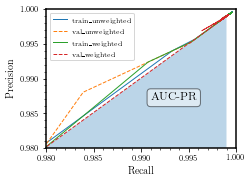

In [ ]:
fig = plt.figure(1,figsize=(1*3.4, 1*3.4*3/4.))
ax = plt.subplot()
plt.plot(baseline_history_unweighted['recall'],  baseline_history_unweighted['precision'], color=colors[0], lw=1,label='train\_unweighted')
plt.plot(baseline_history_unweighted['val_recall'], baseline_history_unweighted['val_precision'],
          color=colors[1], linestyle="--", lw=1, label='val\_unweighted')
plt.plot(baseline_history_loss_weighted['recall'],  baseline_history_loss_weighted['precision'], color=colors[2], lw=1,label='train\_weighted')
plt.plot(baseline_history_loss_weighted['val_recall'], baseline_history_loss_weighted['val_precision'],
          color=colors[3], linestyle="--", lw=1,label='val\_weighted')
plt.fill_between(baseline_history_loss_weighted['val_recall'],  baseline_history_loss_weighted['val_precision'],alpha=0.30)
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0.98,1.0)
plt.ylim(0.98,1.0)
plt.minorticks_on()

textstr = 'AUC-PR'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.55, 0.40, textstr, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.legend()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_pr_curve.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

## DES Predictions

In [ ]:
# reading model file:
keras_model_des = keras.models.load_model('gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/des_tuned_model_loss_weighted.h5')

In [ ]:
# reading ref set:
path_des = 'gdrive/My Drive/Colab Notebooks/des_workspace/'
des_merged3 = pd.read_csv(path_des+'/des_dered_data/des_merged_rob_cuts_distances.csv.gz',compression='gzip',low_memory=False)
des_merged3.shape

(227257, 238)

In [ ]:
# taking out overlap with training set:
overlap = des_merged3.merge(des_tset,on='COADD_OBJECT_ID',how='inner',suffixes=('','_train'))
overlap = overlap.drop(overlap.filter(regex='_train').columns, axis=1)
print('Length of overlap:',len(overlap))

Length of overlap: 63407


In [ ]:
#pred_set = des_merged3[(~des_merged3.COADD_OBJECT_ID.isin(overlap.COADD_OBJECT_ID))]
#pred_set = pred_set.drop(pred_set.filter(regex='_train').columns, axis=1)
#pred_set.shape

In [ ]:
# with object_id to merge after predictions:
refset = des_merged3[['COADD_OBJECT_ID', 'IMAG_DERED', 'ZMAG_DERED',
                     'YMAG_DERED',
                          'w1mpro','w2mpro'
                           ]].dropna(how='any')
print(refset.shape)
# without object_id to prepare for predictions:
refset_mags = refset[['IMAG_DERED', 'ZMAG_DERED',
                      'YMAG_DERED',
                          'w1mpro','w2mpro'
                           ]].dropna(how='any')

features_colors = ccombinator(refset_mags)

features_ref = features_colors.join(refset_mags, how='outer')

print(features_ref.shape)

pred_colors = features_ref.drop(refset_mags,axis=1)

(227257, 6)
(227257, 15)


In [ ]:
# keras predictions:
des_keras_preds = keras_model_des.predict(pred_colors)
np.shape(des_keras_preds)

(227257, 4)

In [ ]:
np.shape(des_keras_preds)

(227257, 4)

In [ ]:
refset['keras_pred_dwarf'] = des_keras_preds[:,0]
refset['keras_pred_giant'] = des_keras_preds[:,1]
refset['keras_pred_galaxy'] = des_keras_preds[:,2]
refset['keras_pred_qso'] = des_keras_preds[:,3]

In [ ]:
# get the predictions here
percent = 0.95
dwarf_pred = refset[refset['keras_pred_dwarf'] >= percent]
print('Pr(Dwarfs) > %.2f:' % percent,len(dwarf_pred))

giant_pred = refset[refset['keras_pred_giant'] > percent]
print('Pr(Giant)> %.2f:' % percent,len(giant_pred))

gal_pred = refset[refset['keras_pred_galaxy'] > percent]
print('Pr(Galaxy) > %.2f:' % percent,len(gal_pred))

qso_pred = refset[refset['keras_pred_qso'] > percent]
print('Pr(QSO) > > %.2f:' % percent,len(qso_pred))

dwarf_frac = len(dwarf_pred)/len(refset)
print("Fraction of total ref set:",dwarf_frac)

Pr(Dwarfs) > 0.95: 81672
Pr(Giant)> 0.95: 1158
Pr(Galaxy) > 0.95: 124869
Pr(QSO) > > 0.95: 93
Fraction of total ref set: 0.35938166921150944


In [ ]:
kiman_dwarfs = des_tset[des_tset['survey_marker'] == 'kiman']

overlap_pred_kiman = kiman_dwarfs.merge(dwarf_pred,on='COADD_OBJECT_ID')

print('Fraction of Kiman in preds:',len(overlap_pred_kiman)/len(kiman_dwarfs))

Fraction of Kiman in preds: 0.9954954954954955


In [ ]:
pred_tset_overlap = des_tset.merge(dwarf_pred,on='COADD_OBJECT_ID')
print('Fraction of pred in tset:',len(pred_tset_overlap)/len(des_tset))

Fraction of pred in tset: 0.9780939013042724


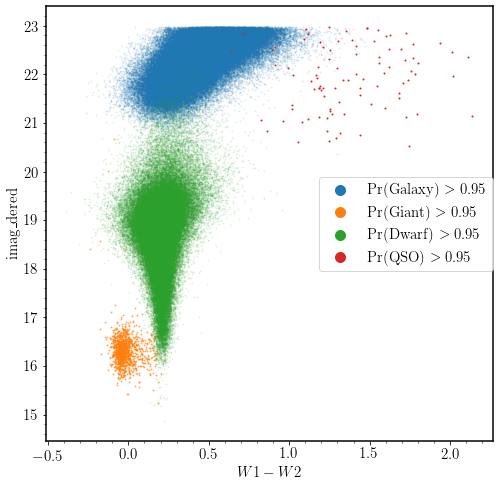

In [ ]:
plt.figure(figsize=(8,8))
ax2=plt.scatter(gal_pred['w1mpro'] - gal_pred['w2mpro'],gal_pred['IMAG_DERED'],
                c='C0',s=1,label='Pr(Galaxy) $> %.2f$' % percent)
ax4 = plt.scatter(giant_pred['w1mpro'] - giant_pred['w2mpro'],giant_pred['IMAG_DERED'],
                  c='C1',s=1,label='Pr(Giant) $> %.2f$' % percent)
ax1=plt.scatter(dwarf_pred['w1mpro'] - dwarf_pred['w2mpro'],dwarf_pred['IMAG_DERED'],
                c='C2',s=1,label='Pr(Dwarf) $> %.2f$' % percent)
ax3 = plt.scatter(qso_pred['w1mpro'] - qso_pred['w2mpro'],qso_pred['IMAG_DERED'],
                  c='C3',s=1,label='Pr(QSO) $> %.2f$' % percent)
plt.xlabel('$W1 - W2$')
plt.ylabel('imag\_dered')
#plt.xlim(0,5)
#plt.ylim(-0.5,2.0)
leg=plt.legend(loc='center right',markerscale=10, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax2.set_alpha(0.1)
ax3.set_alpha(1.0)
ax4.set_alpha(0.5)
#ax5.set_alpha(0.3)
plt.minorticks_on()
plt.savefig('gdrive/My Drive/Colab Notebooks/des_result_plot1_new.pdf',dpi=300)
plt.show()

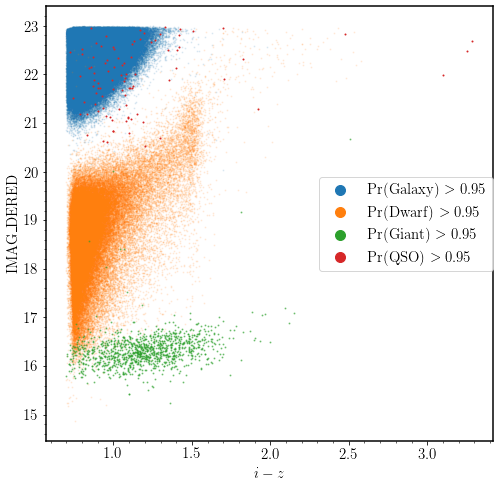

In [ ]:
plt.figure(figsize=(8,8))
ax2=plt.scatter(gal_pred['IMAG_DERED'] - gal_pred['ZMAG_DERED'],gal_pred['IMAG_DERED'],
                c='C0',s=1,label='Pr(Galaxy) $> {}$'.format(percent))
ax1=plt.scatter(dwarf_pred['IMAG_DERED'] - dwarf_pred['ZMAG_DERED'],dwarf_pred['IMAG_DERED'],
                c='C1',s=1,label='Pr(Dwarf) $> {}$'.format(percent))
ax4 = plt.scatter(giant_pred['IMAG_DERED'] - giant_pred['ZMAG_DERED'],giant_pred['IMAG_DERED'],
                  c='C2',s=1,label='Pr(Giant) $> {}$'.format(percent))
ax3 = plt.scatter(qso_pred['IMAG_DERED'] - qso_pred['ZMAG_DERED'],qso_pred['IMAG_DERED'],
                  c='C3',s=1,label='Pr(QSO) $> {}$'.format(percent))
plt.xlabel('$i - z$')
plt.ylabel('IMAG\_DERED')
#plt.xlim(0,5)
#plt.ylim(-0.5,2.0)
leg=plt.legend(loc='center right',markerscale=10, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax2.set_alpha(0.1)
ax3.set_alpha(1.0)
ax4.set_alpha(0.5)
#ax5.set_alpha(0.3)
plt.minorticks_on()
plt.savefig('gdrive/My Drive/Colab Notebooks/des_result_plot2_new.pdf',dpi=300)
plt.show()

## Absolute magnitude profiles

In [ ]:
dwarf_predictions_des = dwarf_pred.merge(des_merged3,on='COADD_OBJECT_ID',suffixes=('','_y'))
dwarf_predictions_des = dwarf_predictions_des.drop(dwarf_predictions_des.filter(regex='_y').columns, axis=1)
print(dwarf_predictions_des.shape)

preds_des_gaia = dwarf_predictions_des[dwarf_predictions_des['parallax'] > 0.0]
preds_des_gaia.shape

(81672, 242)


(72038, 242)

In [ ]:
# dwarfs not in training set
new_des_dwarfs = dwarf_predictions_des[(~dwarf_predictions_des.COADD_OBJECT_ID.isin(des_tset.COADD_OBJECT_ID))]
print(new_des_dwarfs.shape)

new_des_pospar = new_des_dwarfs[new_des_dwarfs['parallax'] > 0.0]
new_des_nopospoar = new_des_dwarfs[(~new_des_dwarfs.COADD_OBJECT_ID.isin(new_des_pospar.COADD_OBJECT_ID))]
print('Non-tset dwarfs with positive parallax:',new_des_pospar.shape)
print('Non-tset dwarfs without parallax:',new_des_nopospoar.shape)

(19657, 242)
Non-tset dwarfs with positive parallax: (10027, 242)
Non-tset dwarfs without parallax: (9630, 242)


In [ ]:
 def abs_mag(d,m):
    return m - 5*np.log10(d) + 5

In [ ]:
preds_des_gaia['M_i'] = abs_mag(preds_des_gaia['rest'],preds_des_gaia['IMAG_DERED'])
preds_des_gaia['M_z'] = abs_mag(preds_des_gaia['rest'],preds_des_gaia['ZMAG_DERED'])
preds_des_gaia['M_Y'] = abs_mag(preds_des_gaia['rest'],preds_des_gaia['YMAG_DERED'])
preds_des_gaia['M_G'] = abs_mag(preds_des_gaia['rest'],preds_des_gaia['phot_g_mean_mag'])
preds_des_gaia['M_w1'] = abs_mag(preds_des_gaia['rest'],preds_des_gaia['w1mpro'])
preds_des_gaia['M_w2'] = abs_mag(preds_des_gaia['rest'],preds_des_gaia['w2mpro'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
new_des_dwarfs['M_i'] = abs_mag(new_des_dwarfs['rest'],new_des_dwarfs['IMAG_DERED'])
new_des_dwarfs['M_z'] = abs_mag(new_des_dwarfs['rest'],new_des_dwarfs['ZMAG_DERED'])
new_des_dwarfs['M_Y'] = abs_mag(new_des_dwarfs['rest'],new_des_dwarfs['YMAG_DERED'])
new_des_dwarfs['M_G'] = abs_mag(new_des_dwarfs['rest'],new_des_dwarfs['phot_g_mean_mag'])
new_des_dwarfs['M_w1'] = abs_mag(new_des_dwarfs['rest'],new_des_dwarfs['w1mpro'])
new_des_dwarfs['M_w2'] = abs_mag(new_des_dwarfs['rest'],new_des_dwarfs['w2mpro'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
def uwe_squared(chi2,obs):
    return chi2/(obs - 5)
    
def uwe_cut(gmag):
    return 1.2*max(1.4,np.exp(-0.2*(float(gmag) - 19.5)))

preds_des_gaia['UWE'] = np.sqrt(uwe_squared(preds_des_gaia['astrometric_chi2_al'],
                                         preds_des_gaia['astrometric_n_obs_al']))

filtered = preds_des_gaia[['COADD_OBJECT_ID','UWE','phot_g_mean_mag']]

# UWE cut:
s = [[col[0],col[1]] for index, col in filtered.T.iteritems() if col[1] < uwe_cut(col[2])]

s_df = pd.DataFrame(s,columns=['COADD_OBJECT_ID','UWE'])
print(s_df.shape)

gaia_dwarfs_clean = s_df.merge(preds_des_gaia,on='COADD_OBJECT_ID',how='inner',suffixes=('','_dup'))
gaia_dwarfs_clean = gaia_dwarfs_clean.drop(gaia_dwarfs_clean.filter(regex='_dup').columns, axis=1)
print(gaia_dwarfs_clean.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(70699, 2)
(70699, 249)


In [ ]:
len(gaia_dwarfs_clean)/len(preds_des_gaia)

0.9814125878008829

In [ ]:
near_dwarfs_des = gaia_dwarfs_clean[gaia_dwarfs_clean['rest'] < 100]
near_dwarfs_des.shape

(2277, 249)

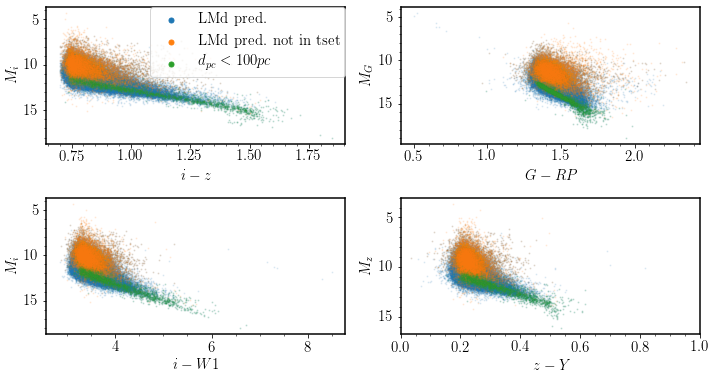

In [ ]:
fig = plt.figure(1,figsize=(3*3.4, 3*3.4*3/4.))
ax = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
#ax5 = fig.add_subplot(325)
#ax6 = fig.add_subplot(326)
plt.subplots_adjust(hspace=2.0)

alpha = 0.1

imag = 'IMAG_DERED'
zmag = 'ZMAG_DERED'
ymag = 'YMAG_DERED'
gmag = 'phot_g_mean_mag'
w1mag = 'w1mpro'
w2mag = 'w2mpro'

axis1=ax.scatter(gaia_dwarfs_clean[imag]-gaia_dwarfs_clean[zmag],gaia_dwarfs_clean['M_i'],
            s=1,c='C0',label='LMd pred.')
axis2=ax.scatter(new_des_dwarfs[imag]-new_des_dwarfs[zmag],new_des_dwarfs['M_i'],
            s=1,c='C1',label='LMd pred. not in tset')
axis3=ax.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_i'],
            s=1,c='C2',label='$d_{pc} < 100pc$')
#ax.set_xscale('symlog')
ax.set_xlabel('$i - z$')
#plt.xlim(-25,125)
#plt.ylim(0.8,4.5)
ax.set_ylabel('$M_i$')
#ax.set_ylim(10,18)
ax.invert_yaxis()
ax.minorticks_on()
leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
axis1.set_alpha(alpha)
axis2.set_alpha(alpha)
axis3.set_alpha(alpha)


ax2.scatter(gaia_dwarfs_clean[gmag] - gaia_dwarfs_clean['phot_rp_mean_mag'],gaia_dwarfs_clean['M_G'],
            s=1,c='C0',alpha=alpha)
ax2.scatter(new_des_dwarfs[gmag]-new_des_dwarfs['phot_rp_mean_mag'],new_des_dwarfs['M_G'],
            s=1,c='C1',alpha=alpha)
ax2.scatter(near_dwarfs_des[gmag] - near_dwarfs_des['phot_rp_mean_mag'],near_dwarfs_des['M_G'],
            s=1,c='C2',alpha=alpha)
ax2.set_xlabel('$G - RP$')
ax2.set_ylabel('$M_G$')
ax2.invert_yaxis()
ax2.minorticks_on()

ax3.scatter(gaia_dwarfs_clean[imag] - gaia_dwarfs_clean[w1mag],gaia_dwarfs_clean['M_i'],
           s=1,c='C0',alpha=alpha)
ax3.scatter(new_des_dwarfs[imag]-new_des_dwarfs[w1mag],new_des_dwarfs['M_i'],
            s=1,c='C1',alpha=alpha)
ax3.scatter(near_dwarfs_des[imag] - near_dwarfs_des[w1mag],near_dwarfs_des['M_i'],
           s=1,c='C2',alpha=alpha)
ax3.set_xlabel('$i - W1$')
ax3.set_ylabel('$M_i$')
ax3.invert_yaxis()
ax3.minorticks_on()

ax4.scatter(gaia_dwarfs_clean[zmag] - gaia_dwarfs_clean[ymag],gaia_dwarfs_clean['M_z'],
           s=1,c='C0',alpha=alpha)
ax4.scatter(new_des_dwarfs[zmag]-new_des_dwarfs[ymag],new_des_dwarfs['M_z'],
            s=1,c='C1',alpha=alpha)
ax4.scatter(near_dwarfs_des[zmag] - near_dwarfs_des[ymag],near_dwarfs_des['M_z'],
           s=1,c='C2',alpha=alpha)
ax4.set_xlabel('$z - Y$')
ax4.set_ylabel('$M_z$')
ax4.invert_yaxis()
ax4.set_xlim(0,1.0)
ax4.minorticks_on()

plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_abs_mag_preds_des_new.pdf',dpi = 300)
plt.show()

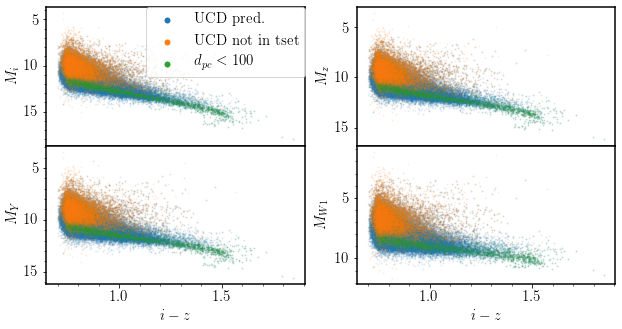

In [ ]:
fig = plt.figure(1,figsize=(3*3.4, 3*3.4*3/4.))
ax = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
#ax5 = fig.add_subplot(325)
#ax6 = fig.add_subplot(326)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

axis1 = ax.scatter(gaia_dwarfs_clean[imag]-gaia_dwarfs_clean[zmag],gaia_dwarfs_clean['M_i'],
            s=1,c='C0',label='UCD pred.')
axis2 = ax.scatter(new_des_dwarfs[imag]-new_des_dwarfs[zmag],new_des_dwarfs['M_i'],
            s=1,c='C1',label='UCD not in tset')
axis3 = ax.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_i'],
            s=1,c='C2',label='$d_{pc} < 100$')
ax.set_xlabel('$i - z$')
#plt.xlim(-25,125)
#plt.ylim(0.8,4.5)
ax.set_ylabel('$M_i$')
ax.invert_yaxis()
ax.minorticks_on()
leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
axis1.set_alpha(alpha)
axis2.set_alpha(alpha)
axis3.set_alpha(alpha)

ax2.scatter(gaia_dwarfs_clean[imag]-gaia_dwarfs_clean[zmag],gaia_dwarfs_clean['M_z'],
            s=1,c='C0',alpha=alpha)
ax2.scatter(new_des_dwarfs[imag]-new_des_dwarfs[zmag],new_des_dwarfs['M_z'],
            s=1,c='C1',alpha=alpha)
ax2.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_z'],
            s=1,c='C2',alpha=alpha)
ax2.set_xlabel('$i - z$')
ax2.set_ylabel('$M_z$')
ax2.invert_yaxis()

ax3.scatter(gaia_dwarfs_clean[imag]-gaia_dwarfs_clean[zmag],gaia_dwarfs_clean['M_Y'],
            s=1,c='C0',alpha=alpha)
ax3.scatter(new_des_dwarfs[imag]-new_des_dwarfs[zmag],new_des_dwarfs['M_Y'],
            s=1,c='C1',alpha=alpha)
ax3.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_Y'],
            s=1,c='C2',alpha=alpha)
ax3.set_xlabel('$i - z$')
ax3.set_ylabel('$M_Y$')
ax3.invert_yaxis()
ax3.minorticks_on()

ax4.scatter(gaia_dwarfs_clean[imag]-gaia_dwarfs_clean[zmag],gaia_dwarfs_clean['M_w1'],
            s=1,c='C0',alpha=alpha)
ax4.scatter(new_des_dwarfs[imag]-new_des_dwarfs[zmag],new_des_dwarfs['M_w1'],
            s=1,c='C1',alpha=alpha)
ax4.scatter(near_dwarfs_des[imag]-near_dwarfs_des[zmag],near_dwarfs_des['M_w1'],
            s=1,c='C2',alpha=alpha)
ax4.set_xlabel('$i - z$')
ax4.set_ylabel('$M_{W1}$')
#ax4.set_ylim(2.0,12)
ax4.invert_yaxis()
ax4.minorticks_on()

plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_abs_mag_iz_preds_new.pdf',dpi=300)
plt.show()

In [ ]:
dwarfs_nopar_des = dwarf_predictions_des[(~dwarf_predictions_des.COADD_OBJECT_ID.isin(preds_des_gaia.COADD_OBJECT_ID))]
dwarfs_nopar_des.shape

(9634, 242)

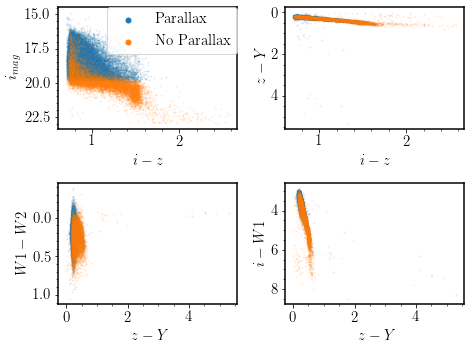

In [ ]:
fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
plt.subplot(2,2,1)

alpha = 0.1

ax1=plt.scatter(gaia_dwarfs_clean[imag]-gaia_dwarfs_clean[zmag],gaia_dwarfs_clean[imag],
           s=1,c='C0',label='Parallax')
ax2=plt.scatter(dwarfs_nopar_des[imag]-dwarfs_nopar_des[zmag],dwarfs_nopar_des[imag],
           s=1,c='C1',label='No Parallax')
plt.xlabel('$i - z$')
plt.ylabel('$i_{mag}$')
plt.minorticks_on()
plt.legend()
plt.gca().invert_yaxis()
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.subplot(2,2,2)
ax1=plt.scatter(gaia_dwarfs_clean[imag]-gaia_dwarfs_clean[zmag],gaia_dwarfs_clean[zmag]-gaia_dwarfs_clean[ymag],
           s=1,c='C0')
ax2=plt.scatter(dwarfs_nopar_des[imag]-dwarfs_nopar_des[zmag],dwarfs_nopar_des[zmag]-dwarfs_nopar_des[ymag],
           s=1,c='C1')
plt.xlabel('$i - z$')
plt.ylabel('$z - Y$')
plt.minorticks_on()
plt.gca().invert_yaxis()
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.subplot(2,2,3)
ax1=plt.scatter(gaia_dwarfs_clean[zmag]-gaia_dwarfs_clean[ymag],gaia_dwarfs_clean[w1mag]-gaia_dwarfs_clean[w2mag],
           s=1,c='C0',label='Parallax')
ax2=plt.scatter(dwarfs_nopar_des[zmag]-dwarfs_nopar_des[ymag],dwarfs_nopar_des[w1mag]-dwarfs_nopar_des[w2mag],
           s=1,c='C1')
plt.xlabel('$z - Y$')
plt.ylabel('$W1 - W2$')
plt.minorticks_on()
#plt.legend()
plt.gca().invert_yaxis()
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.subplot(2,2,4)
ax1=plt.scatter(gaia_dwarfs_clean[zmag]-gaia_dwarfs_clean[ymag],gaia_dwarfs_clean[imag]-gaia_dwarfs_clean[w1mag],
           s=1,c='C0',label='Parallax')
ax2=plt.scatter(dwarfs_nopar_des[zmag]-dwarfs_nopar_des[ymag],dwarfs_nopar_des[imag]-dwarfs_nopar_des[w1mag],
           s=1,c='C1')
plt.xlabel('$z - Y$')
plt.ylabel('$i - W1$')
plt.minorticks_on()
plt.gca().invert_yaxis()
ax1.set_alpha(alpha)
ax2.set_alpha(alpha)

plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_par_nopar_preds_new.pdf',dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
all_predictions_des = refset.merge(des_merged3,on='COADD_OBJECT_ID',suffixes=('','_y'))
all_predictions_des = all_predictions_des.drop(all_predictions_des.filter(regex='_y').columns, axis=1)
print(all_predictions_des.shape)

(227257, 242)


In [ ]:
all_predictions_des.to_csv('gdrive/My Drive/Colab Notebooks/ml_preds/des_preds_ktuner_weighted_rob_cuts_new.csv.gz',compression='gzip',index=False)

# SMSS

## SMSS Data Prep

In [ ]:
path_sm = 'gdrive/My Drive/Colab Notebooks/sm_workspace/'
smss_tset = pd.read_csv(path_sm+'smss_red_trainingset_nodupes.csv.gz',compression='gzip',low_memory=False)
print('Training set shape:',smss_tset.shape)
print(Counter(smss_tset['label']))
print(Counter(smss_tset['survey_marker']))

Training set shape: (28849, 368)
Counter({'lm*': 28768, 'hm*': 81})
Counter({'smss_gaia_parallax': 28639, 'gagne_m': 137, 'kiman': 67, 'gagne_lty': 6})


In [ ]:
feature_list = ['i_psf','z_psf',
                'j_m','h_m','k_m',
                'w1mpro','w2mpro'
                ]
label = ['label']
tmags = smss_tset[feature_list + label]
tmags2 = tmags.dropna(how='any')
tmags3 = tmags2[feature_list]
print('Training magnitudes shape:',tmags3.shape)
# Combination function:
def ccombinator(x):
    mags = pd.DataFrame(index=x.index)
    for a, b, in combinations(x.columns, 2):
        mags['{}-{}'.format(a, b)] = x[a] - x[b]
    c = mags
    return c

train_features = ccombinator(tmags3).join(tmags3, how='outer')

ytarget = tmags2['label']
print('Size of training features:',train_features.shape)
train_colors = train_features.drop(feature_list,axis=1)
print('Size of training colors:',train_colors.shape)

ytarget = tmags2['label']

Training magnitudes shape: (28849, 7)
Size of training features: (28849, 28)
Size of training colors: (28849, 21)


In [ ]:
Counter(ytarget)

Counter({'hm*': 81, 'lm*': 28768})

In [ ]:
binary_label = []
for label in ytarget:
  if label == 'lm*':
    binary_label.append(1) # change back to 1. Testing labels
  else:
    binary_label.append(0)

# splitting data into train and validation set:
X_train, X_test, y_train, y_test = train_test_split(train_colors, binary_label, 
                                                    test_size=0.50, random_state=42,shuffle=True)

np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test)

weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights_smss = {0: weights[0], 1: weights[1]}
class_weights_smss

{0: 206.05714285714285, 1: 0.5012162068246577}

In [ ]:
d,h = np.bincount(binary_label)
total = np.sum([d,h])
print('Examples:\n    Total: {}\n    hm*: {} ({:.2f}% of total)\n'.format(
    total, h, 100 * h / total))

Examples:
    Total: 28849
    hm*: 28768 (99.72% of total)



In [ ]:
initial_bias = np.log([h/d])
initial_bias

array([5.87256978])

In [ ]:
weights_list = []
for label in y_train:
  if label == 0:
    weights_list.append(weights[0])
  else:
    weights_list.append(weights[1])
np.shape(weights_list)

(14424,)

## SMSS Training

In [ ]:
METRICS = [
      k_metrics.Precision(name='precision'),
      k_metrics.Recall(name='recall'),
      k_metrics.AUC(name='auc'),
      k_metrics.BinaryAccuracy(name='accuracy')
]

def model_builder(hp):
  model = keras.Sequential()
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  output_bias = tf.keras.initializers.Constant(initial_bias)
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  
  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4])
  # activation layer:
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu',input_dim=X_train.shape[1]))

  for i in range(hp.Int('num_layers', min_value = 2, max_value = 6,step=2)):
    model.add(keras.layers.Dense(units=hp_units, activation='relu')) # hidden layers
  model.add(Dense(1,activation='sigmoid',
                  bias_initializer=output_bias # biased output layer
                  )) 

  model.compile(loss='binary_crossentropy'
                      ,optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
                      ,metrics=METRICS # metrics
                      #,loss_weights=weights_list
                )
   
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 200,
                     factor = 10,
                     directory = 'gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/',
                     project_name = 'SMSS_tuning_loss_unweighted_biased7') # revert to previous by deleting '_unbiased'. Biased 7 is the latest. Unbiased didn't get rid of the bright sequence

INFO:tensorflow:Reloading Oracle from existing project gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/SMSS_tuning_loss_unweighted_biased7/oracle.json
INFO:tensorflow:Reloading Tuner from gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/SMSS_tuning_loss_unweighted_biased7/tuner0.json


In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(np.array(X_train), np.array(y_train), epochs = 200, validation_data = (np.array(X_test), np.array(y_test)), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The best number of layers is {best_hps.get('num_layers')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal learning rate for the optimizer
is 0.001. The best number of layers is 2.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
baseline_history = model.fit(np.array(X_train), np.array(y_train), epochs = 200, validation_data = (np.array(X_test), np.array(y_test)), 
                             #class_weight=class_weight, # adding class weights to improve the imbalanced classification
                             batch_size=500, verbose=1)

Epoch 1/200
29/29 [==============================] - 1s 21ms/step - loss: 0.0167 - precision: 0.9983 - recall: 0.9998 - auc: 0.7384 - accuracy: 0.9981 - val_loss: 0.0206 - val_precision: 0.9968 - val_recall: 1.0000 - val_auc: 0.5647 - val_accuracy: 0.9968
Epoch 2/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0157 - precision: 0.9976 - recall: 1.0000 - auc: 0.5424 - accuracy: 0.9976 - val_loss: 0.0199 - val_precision: 0.9968 - val_recall: 1.0000 - val_auc: 0.7990 - val_accuracy: 0.9968
Epoch 3/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0148 - precision: 0.9976 - recall: 1.0000 - auc: 0.7707 - accuracy: 0.9976 - val_loss: 0.0187 - val_precision: 0.9968 - val_recall: 1.0000 - val_auc: 0.7165 - val_accuracy: 0.9968
Epoch 4/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0125 - precision: 0.9976 - recall: 1.0000 - auc: 0.8395 - accuracy: 0.9976 - val_loss: 0.0155 - val_precision: 0.9969 - val_recall: 0.9998 - val_auc: 0.8609 - 

In [ ]:
  model.save('gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/smss_tuned_model_loss_unweighted_biased2.h5') # take off _newlabeltest to revert to previous
  f = open('gdrive/My Drive/Colab Notebooks/ml_preds/keras_des_histories/smss_tuned_history_loss_unweighted_biased2.pckl', 'wb') # compare to _weighted when it's done!
  pickle.dump(baseline_history.history, f)
  f.close()

## Plotting metrics

In [6]:
baseline_history_sm_unweighted = pd.read_pickle(r'gdrive/My Drive/Colab Notebooks/ml_preds/keras_des_histories/smss_tuned_history_loss_unweighted_biased2.pckl')
baseline_history_sm_weighted = pd.read_pickle(r'gdrive/My Drive/Colab Notebooks/ml_preds/keras_des_histories/smss_tuned_history_loss_weighted_biased2.pckl')

# smss_tuned_history_loss_unweighted_biased2
# smss_tuned_history_loss_weighted_biased2

In [ ]:
def plot_metrics(history1,history2=None):
  metrics =  ['loss', 'accuracy', 'precision', 'recall']
  epochs = range(len(history1['accuracy']))
  fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
  plt.subplots_adjust(hspace=0.0)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(epochs,  history1[metric], color=colors[0],lw=1, label='train\_unweighted')
    plt.plot(epochs, history1['val_'+metric],
             color=colors[1], linestyle="--", lw=1,label='val\_unweighted')
    if history2:
      plt.plot(epochs,  history2[metric], color=colors[2], lw=1,label='train\_weighted')
      plt.plot(epochs, history2['val_'+metric],
              color=colors[3], linestyle="--", lw=1,label='val\_weighted')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.minorticks_on()
    if metric == 'loss':
      plt.legend()
    else:
      plt.ylim(0.995,1.0)
  plt.minorticks_on()
  plt.tight_layout()
  plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_training_metric_plots.pdf',dpi=300,bbox_inches='tight',padding=0)
  plt.show()

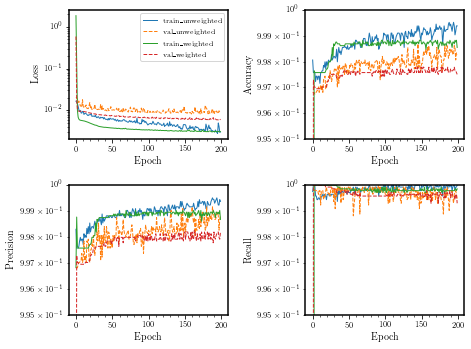

In [ ]:
plot_metrics(baseline_history_sm_unweighted,history2=baseline_history_sm_weighted)

In [7]:
def plot_metrics2(history1,history2):
  metrics =  ['loss', 'accuracy', 'precision', 'recall']
  epochs = range(len(history2['accuracy']))
  fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
  plt.subplots_adjust(hspace=0.0)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(epochs,  history2[metric], color=colors[0],lw=1, label='SMSS weighted train')
    plt.plot(epochs, history2['val_'+metric],
             color=colors[1], linestyle="--", lw=1,label='SMSS weighted val')
    plt.plot(epochs,  history1[metric], color=colors[2], lw=1,label='DES weighted train')
    plt.plot(epochs, history1['val_'+metric],
             color=colors[3], linestyle="--", lw=1,label='DES weighted val')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.minorticks_on()
    if metric == 'loss':
      plt.legend()
      #plt.ylim([0, 0.1])
    else:
      plt.ylim([0.995,1.0])
  plt.minorticks_on()
  plt.tight_layout()
  plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_des_weighted_validation_metric_plots.pdf',dpi=300,bbox_inches='tight',padding=0)
  plt.show()

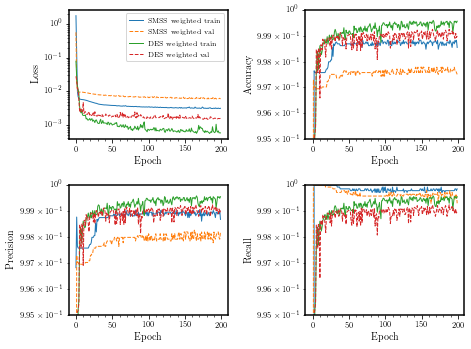

In [8]:
plot_metrics2(baseline_history_loss_weighted,baseline_history_sm_weighted)

## SMSS Predictions

In [ ]:
# reading model file:
keras_model_sm = keras.models.load_model('gdrive/My Drive/Colab Notebooks/ml_preds/keras_hyperband_tuner/smss_tuned_model_loss_weighted_biased2.h5')

# smss_tuned_model_loss_weighted_biased2.h5 <--- previous

In [ ]:
y_pred = keras_model_sm(X_test)

conf_matrix = tf.math.confusion_matrix(y_test,y_pred)
conf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[   46,     0],
       [14308,    71]], dtype=int32)>

In [ ]:
sm_path = 'gdrive/My Drive/Colab Notebooks/sm_workspace/'
smss_refset = pd.read_csv(sm_path+'smss_merged3.csv.gz',compression='gzip',low_memory=False)
print('skymapper refset shape:',smss_refset.shape)

skymapper refset shape: (36262, 363)


In [ ]:
# seeing if this gets rid of the brighter sequence
smss_refset = smss_refset[smss_refset['ebmv_sfd'] < 1.0]
smss_refset.shape

(36262, 363)

In [ ]:
# with object_id to merge after predictions:
refset_sm = smss_refset[['object_id', 'i_psf', 'z_psf',
                          'j_m', 'h_m','k_m',
                           'w1mpro', 'w2mpro'
                           ]].dropna(how='any')

# without object_id to prepare for predictions:
refset_mags_sm = refset_sm[['i_psf', 'z_psf',
                          'j_m', 'h_m','k_m',
                           'w1mpro', 'w2mpro'
                           ]].dropna(how='any')

features_colors_sm = ccombinator(refset_mags_sm)

features_ref_sm = features_colors_sm.join(refset_mags_sm, how='outer')
pred_colors_sm = features_ref_sm.drop(refset_mags_sm,axis=1)
print(pred_colors_sm.shape)

(36262, 21)


In [ ]:
# keras predictions:
sm_keras_preds = keras_model_sm.predict(pred_colors_sm)

In [ ]:
refset_sm['keras_pred_dwarf'] = sm_keras_preds

In [ ]:
# get the predictions here
percent1 = 0.95 
dwarf_pred_sm = refset_sm[refset_sm['keras_pred_dwarf'] >= percent1]
print('Pr(Dwarfs) > %.2f:' % percent1,len(dwarf_pred_sm))

other_pred_sm = refset_sm[refset_sm['keras_pred_dwarf'] < percent1]
print('Pr(Dwarf) < %.2f:' % percent1,len(other_pred_sm))

dwarf_frac = len(dwarf_pred_sm)/len(smss_refset)
print("Fraction of total ref set:",dwarf_frac)

Pr(Dwarfs) > 0.95: 35960
Pr(Dwarf) < 0.95: 302
Fraction of total ref set: 0.9916717224642877


In [ ]:
kiman_dwarfs_sm = smss_tset[smss_tset['survey_marker'] == 'kiman']

overlap_pred_sm_kiman = dwarf_pred_sm.merge(kiman_dwarfs_sm,on='object_id')

print('Fraction of predictions in Kiman:',len(overlap_pred_sm_kiman)/len(kiman_dwarfs_sm))

Fraction of predictions in Kiman: 1.0


In [ ]:
(dwarf_pred_sm['i_psf'] - dwarf_pred_sm['z_psf']).min()

0.7499999999999964

In [ ]:
dwarfs_smss_red = dwarf_pred_sm[dwarf_pred_sm['i_psf'] - dwarf_pred_sm['z_psf'] >= 0.75]
dwarfs_smss_red.shape

(35952, 9)

In [ ]:
pred_tset_overlap = smss_tset.merge(dwarfs_smss_red,on='object_id')
print('Fractino of pred in tset:',len(pred_tset_overlap)/len(smss_tset))

Fractino of pred in tset: 0.9918541370584769


In [ ]:
dwarf_predictions_sm = dwarfs_smss_red.merge(smss_refset,on='object_id',suffixes=('','_y'))
dwarf_predictions_sm = dwarf_predictions_sm.drop(dwarf_predictions_sm.filter(regex='_y').columns, axis=1)
print(dwarf_predictions_sm.shape)

(35952, 364)


In [ ]:
# dwarfs not in training set
new_smss_dwarfs = dwarf_predictions_sm[(~dwarf_predictions_sm.object_id.isin(smss_tset.object_id))]
print(new_smss_dwarfs.shape)

new_smss_pospar = new_smss_dwarfs[new_smss_dwarfs['parallax'] > 0.0]
new_smss_nopospoar = new_smss_dwarfs[(~new_smss_dwarfs.object_id.isin(new_smss_pospar.object_id))]
print('Non-tset dwarfs with positive parallax:',new_smss_pospar.shape)
print('Non-tset dwarfs without parallax:',new_smss_nopospoar.shape)

(7338, 364)
Non-tset dwarfs with positive parallax: (3637, 364)
Non-tset dwarfs without parallax: (3701, 364)


In [ ]:
dwarf_gaia_par = dwarf_predictions_sm[dwarf_predictions_sm['parallax'] > 0.0]
dwarf_gaia_par.shape

(32251, 364)

## Absolute magnitude profile

In [ ]:
def abs_mag(d,m):
    return m - 5*np.log10(d) + 5

# getting absolute magnitudes for each band:
dwarf_gaia_par['M_i'] = abs_mag(dwarf_gaia_par['rest'],dwarf_gaia_par['i_psf'])
dwarf_gaia_par['M_z'] = abs_mag(dwarf_gaia_par['rest'],dwarf_gaia_par['z_psf'])
dwarf_gaia_par['M_G'] = abs_mag(dwarf_gaia_par['rest'],dwarf_gaia_par['phot_g_mean_mag'])
dwarf_gaia_par['M_J'] = abs_mag(dwarf_gaia_par['rest'],dwarf_gaia_par['j_m'])
dwarf_gaia_par['M_H'] = abs_mag(dwarf_gaia_par['rest'],dwarf_gaia_par['h_m'])
dwarf_gaia_par['M_K'] = abs_mag(dwarf_gaia_par['rest'],dwarf_gaia_par['k_m'])
dwarf_gaia_par['M_w1'] = abs_mag(dwarf_gaia_par['rest'],dwarf_gaia_par['w1mpro'])
dwarf_gaia_par['M_w2'] = abs_mag(dwarf_gaia_par['rest'],dwarf_gaia_par['w2mpro'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
new_smss_pospar['M_i'] = abs_mag(new_smss_pospar['rest'],new_smss_pospar['i_psf'])
new_smss_pospar['M_z'] = abs_mag(new_smss_pospar['rest'],new_smss_pospar['z_psf'])
new_smss_pospar['M_G'] = abs_mag(new_smss_pospar['rest'],new_smss_pospar['phot_g_mean_mag'])
new_smss_pospar['M_J'] = abs_mag(new_smss_pospar['rest'],new_smss_pospar['j_m'])
new_smss_pospar['M_H'] = abs_mag(new_smss_pospar['rest'],new_smss_pospar['h_m'])
new_smss_pospar['M_K'] = abs_mag(new_smss_pospar['rest'],new_smss_pospar['k_m'])
new_smss_pospar['M_w1'] = abs_mag(new_smss_pospar['rest'],new_smss_pospar['w1mpro'])
new_smss_pospar['M_w2'] = abs_mag(new_smss_pospar['rest'],new_smss_pospar['w2mpro'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
# removing binary sequence attempt:
def uwe_squared(chi2,obs):
    return chi2/(obs - 5)
    
def uwe_cut(gmag):
    return 1.2*max(1.4,np.exp(-0.2*(float(gmag) - 19.5)))

dwarf_gaia_par['UWE'] = np.sqrt(uwe_squared(dwarf_gaia_par['astrometric_chi2_al'],
                                         dwarf_gaia_par['astrometric_n_obs_al']))

filtered = dwarf_gaia_par[['object_id','UWE','phot_g_mean_mag']]

# UWE cut:
s = [[col[0],col[1]] for index, col in filtered.T.iteritems() if col[1] < uwe_cut(col[2])]

s_df = pd.DataFrame(s,columns=['object_id','UWE'])
s_df.shape

clean_new_dwarfs = s_df.merge(dwarf_gaia_par,on='object_id',how='inner',suffixes=('','_dup'))
clean_new_dwarfs = clean_new_dwarfs.drop(clean_new_dwarfs.filter(regex='_dup').columns, axis=1)
clean_new_dwarfs.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(30820, 373)

In [ ]:
len(clean_new_dwarfs)/len(dwarf_gaia_par)

0.955629282812936

In [ ]:
# cutting distance:
clean_new_dwarfs['d_pc'] = 1000.0/clean_new_dwarfs['parallax']

near_dwarfs = clean_new_dwarfs[clean_new_dwarfs['d_pc'] < 100]
near_dwarfs.shape

(2639, 374)

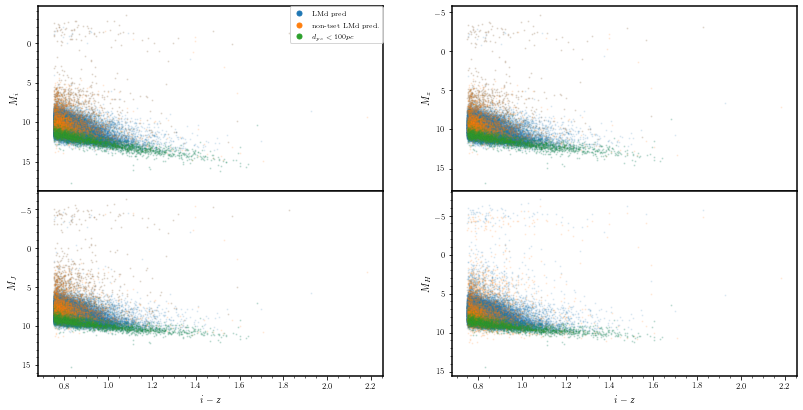

In [ ]:
fig = plt.figure(1,figsize=(4*3.4, 4*3.4*3/4.))
ax = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
plt.subplots_adjust(hspace=0.0)

alpha = 0.1

axis1 = ax.scatter(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_i'],
            s=1,c='C0',label='LMd pred')
axis2 = ax.scatter(new_smss_pospar['i_psf']-new_smss_pospar['z_psf'],new_smss_pospar['M_i'],
            s=1,c='C1',label='non-tset LMd pred.')
axis3 = ax.scatter(near_dwarfs['i_psf']-near_dwarfs['z_psf'],near_dwarfs['M_i'],
            s=1,c='C2',label='$d_{pc} < 100pc$')
ax.set_xlabel('$i - z$')
#plt.xlim(-25,125)
#plt.ylim(0.8,4.5)
ax.set_ylabel('$M_i$')
ax.invert_yaxis()
ax.minorticks_on()
leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
axis1.set_alpha(alpha)
axis2.set_alpha(alpha)
axis3.set_alpha(alpha)

ax2.scatter(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_z'],
            s=1,c='C0',alpha=0.1,label='LMd pred')
ax2.scatter(new_smss_pospar['i_psf']-new_smss_pospar['z_psf'],new_smss_pospar['M_z'],
            s=1,c='C1',label='non-tset LMd pred.',alpha=0.1)
ax2.scatter(near_dwarfs['i_psf']-near_dwarfs['z_psf'],near_dwarfs['M_z'],
            s=1,c='C2',alpha=0.1,label='$d_{pc} < 100pc$')
ax2.set_xlabel('$i - z$')
ax2.set_ylabel('$M_z$')
ax2.invert_yaxis()

ax3.scatter(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_J'],
            s=1,c='C0',alpha=alpha)
ax3.scatter(new_smss_pospar['i_psf']-new_smss_pospar['z_psf'],new_smss_pospar['M_J'],
            s=1,c='C1',alpha=alpha)
ax3.scatter(near_dwarfs['i_psf']-near_dwarfs['z_psf'],near_dwarfs['M_J'],
            s=1,c='C2',alpha=alpha)
ax3.set_xlabel('$i - z$')
ax3.set_ylabel('$M_J$')
ax3.invert_yaxis()
ax3.minorticks_on()

ax4.scatter(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_H'],
            s=1,c='C0',alpha=alpha)
ax4.scatter(new_smss_pospar['i_psf']-new_smss_pospar['z_psf'],new_smss_pospar['M_J'],
            s=1,c='C1',alpha=alpha)
ax4.scatter(near_dwarfs['i_psf']-near_dwarfs['z_psf'],near_dwarfs['M_H'],
            s=1,c='C2',alpha=alpha)
ax4.set_xlabel('$i - z$')
ax4.set_ylabel('$M_H$')
ax4.invert_yaxis()
ax4.minorticks_on()

plt.show()

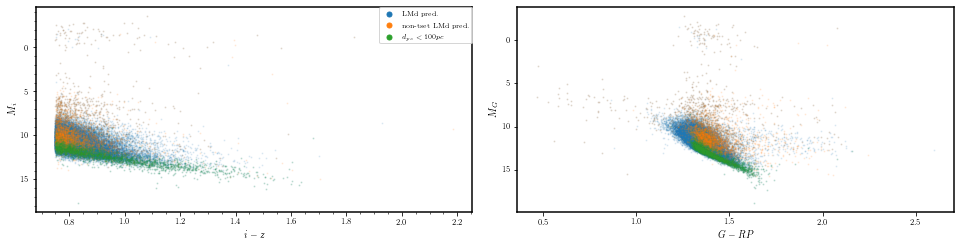

In [ ]:
fig = plt.figure(1,figsize=(4*3.4, 4*3.4*3/4.))
ax = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
#ax3 = fig.add_subplot(323)
#ax4 = fig.add_subplot(324)
#ax5 = fig.add_subplot(325)
#ax6 = fig.add_subplot(326)
plt.subplots_adjust(hspace=0.0)
alpha = 0.1

axis1 = ax.scatter(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_i'],
            s=1,c='C0',label='LMd pred.')
axis2 = ax.scatter(new_smss_pospar['i_psf']-new_smss_pospar['z_psf'],new_smss_pospar['M_i'],
            s=1,c='C1',label='non-tset LMd pred.')
axis3 = ax.scatter(near_dwarfs['i_psf']-near_dwarfs['z_psf'],near_dwarfs['M_i'],
            s=1,c='C2',label='$d_{pc} < 100pc$')
ax.set_xlabel('$i - z$')
#plt.xlim(-25,125)
#plt.ylim(0.8,4.5)
ax.set_ylabel('$M_i$')
ax.invert_yaxis()
ax.minorticks_on()
leg=ax.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
axis1.set_alpha(alpha)
axis2.set_alpha(alpha)
axis3.set_alpha(alpha)


ax2.scatter(clean_new_dwarfs['phot_g_mean_mag'] - clean_new_dwarfs['phot_rp_mean_mag'],clean_new_dwarfs['M_G'],
            s=1,c='C0',alpha=alpha,label='dwarf predictions')
ax2.scatter(new_smss_pospar['phot_g_mean_mag']-new_smss_pospar['phot_rp_mean_mag'],new_smss_pospar['M_G'],
            s=1,c='C1',alpha=alpha)
ax2.scatter(near_dwarfs['phot_g_mean_mag'] - near_dwarfs['phot_rp_mean_mag'],near_dwarfs['M_G'],
            s=1,c='C2',alpha=alpha,label='$d_{pc} < 100pc$')
ax2.set_xlabel('$G - RP$')
ax2.set_ylabel('$M_G$')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
df = clean_new_dwarfs[['M_G','phot_g_mean_mag','phot_rp_mean_mag']].dropna(how='any')
df.shape

(30384, 3)

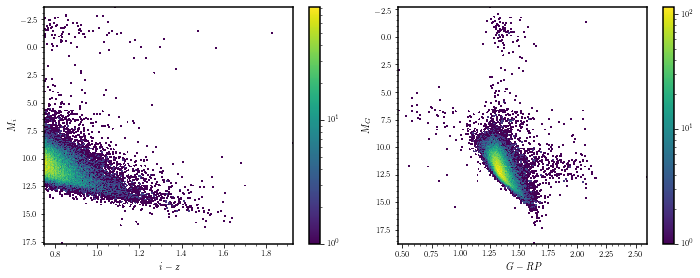

In [ ]:
fig = plt.figure(1,figsize=(3*3.4, 3*3.4*3/4.))
plt.subplot(2,2,1)
bins=250

plt.hist2d(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_i'],bins=bins,
           norm=LogNorm()
           #,range=[[0,3],[-10,10]]
          )
plt.colorbar()
plt.xlabel('$i - z$')
plt.ylabel('$M_i$')
#plt.ylim(0,18)
plt.gca().invert_yaxis()
plt.minorticks_on()
#ax.show()


plt.subplot(2,2,2)
plt.hist2d(df['phot_g_mean_mag'] - df['phot_rp_mean_mag'],df['M_G'].dropna(how='any'),bins=bins,
           norm=LogNorm()
           #,range=[[0,3],[-10,10]]
          )
plt.xlabel('$G - RP$')
plt.ylabel('$M_G$')
plt.colorbar()
plt.gca().invert_yaxis()

plt.minorticks_on()
plt.tight_layout()
plt.show()

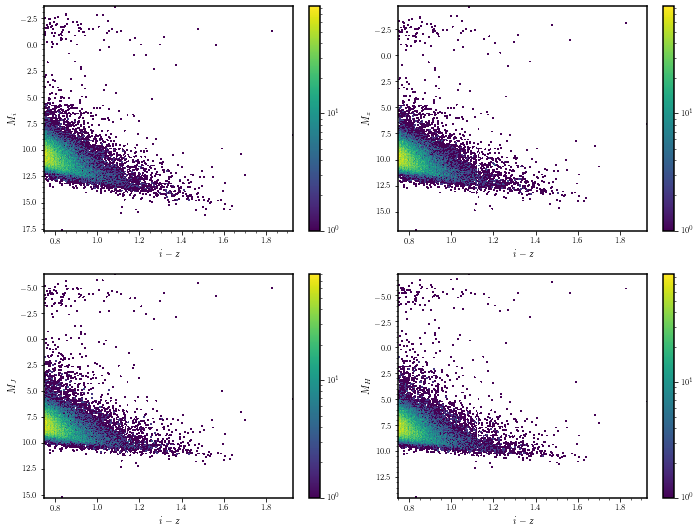

In [ ]:
fig = plt.figure(1,figsize=(3*3.4, 3*3.4*3/4.))
plt.subplot(2,2,1)
bins=250

plt.hist2d(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_i'],bins=bins,
           norm=LogNorm()
           #,range=[[0,3],[-10,10]]
          )
plt.colorbar()
plt.xlabel('$i - z$')
plt.ylabel('$M_i$')
#plt.ylim(0,18)
plt.gca().invert_yaxis()
plt.minorticks_on()
#ax.show()


plt.subplot(2,2,2)
plt.hist2d(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_z'],bins=bins,
           norm=LogNorm()
           #,range=[[0,3],[-10,10]]
          )
plt.xlabel('$i - z$')
plt.ylabel('$M_z$')
#plt.ylim(0,18)
plt.colorbar()
plt.gca().invert_yaxis()


plt.subplot(2,2,3)
plt.hist2d(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_J'],bins=bins,
           norm=LogNorm()
           #,range=[[0,3],[-10,10]]
          )
plt.xlabel('$i - z$')
plt.ylabel('$M_J$')
#plt.ylim(0,18)
plt.colorbar()
plt.gca().invert_yaxis()

plt.subplot(2,2,4)
plt.hist2d(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['M_H'],bins=bins,
           norm=LogNorm()
           #,range=[[0,3],[-10,10]]
          )
plt.xlabel('$i - z$')
plt.ylabel('$M_H$')
#plt.ylim(0,18)
plt.colorbar()
plt.gca().invert_yaxis()

plt.minorticks_on()
plt.tight_layout()
plt.show()

In [ ]:
dwarfs_nopar = dwarf_predictions_sm[(~dwarf_predictions_sm.object_id.isin(dwarf_gaia_par.object_id))]
dwarfs_nopar.shape

(3701, 364)

In [ ]:
len(dwarfs_nopar)/(len(dwarf_gaia_par)+len(dwarfs_nopar))

0.10294281263907432

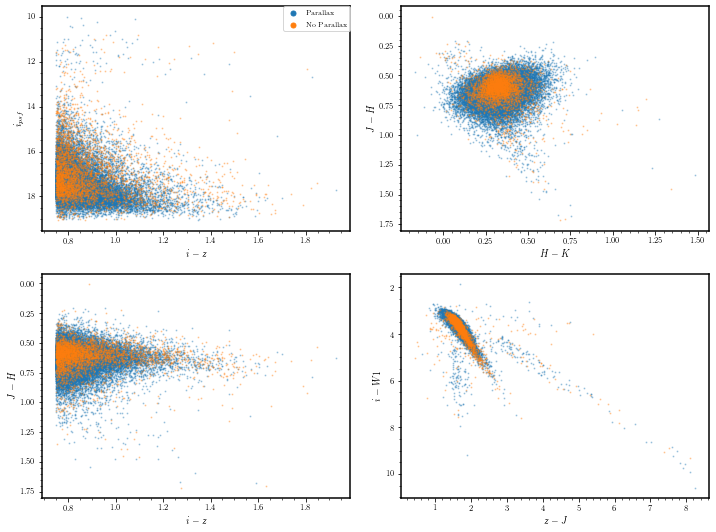

In [ ]:
fig = plt.figure(1,figsize=(3*3.4, 3*3.4*3/4.))
plt.subplot(2,2,1)
ax1=plt.scatter(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['i_psf'],
           s=1,c='C0',label='Parallax')
ax2=plt.scatter(dwarfs_nopar['i_psf']-dwarfs_nopar['z_psf'],dwarfs_nopar['i_psf'],
           s=1,c='C1',label='No Parallax')
plt.xlabel('$i - z$')
plt.ylabel('$i_{psf}$')
plt.minorticks_on()
plt.legend()
plt.gca().invert_yaxis()
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.3)
ax2.set_alpha(0.3)

plt.subplot(2,2,2)
ax1=plt.scatter(clean_new_dwarfs['h_m']-clean_new_dwarfs['k_m'],clean_new_dwarfs['j_m']-clean_new_dwarfs['h_m'],
           s=1,c='C0')
ax2=plt.scatter(dwarfs_nopar['h_m']-dwarfs_nopar['k_m'],dwarfs_nopar['j_m']-dwarfs_nopar['h_m'],
           s=1,c='C1')
plt.xlabel('$H - K$')
plt.ylabel('$J - H$')
plt.minorticks_on()
plt.gca().invert_yaxis()
ax1.set_alpha(0.3)
ax2.set_alpha(0.3)

plt.subplot(2,2,3)
ax1=plt.scatter(clean_new_dwarfs['i_psf']-clean_new_dwarfs['z_psf'],clean_new_dwarfs['j_m']-clean_new_dwarfs['h_m'],
           s=1,c='C0',label='Parallax')
ax2=plt.scatter(dwarfs_nopar['i_psf']-dwarfs_nopar['z_psf'],dwarfs_nopar['j_m']-dwarfs_nopar['h_m'],
           s=1,c='C1')
plt.xlabel('$i - z$')
plt.ylabel('$J - H$')
plt.minorticks_on()
#plt.legend()
plt.gca().invert_yaxis()
ax1.set_alpha(0.3)
ax2.set_alpha(0.3)

plt.subplot(2,2,4)
ax1=plt.scatter(clean_new_dwarfs['z_psf']-clean_new_dwarfs['j_m'],clean_new_dwarfs['i_psf']-clean_new_dwarfs['w1mpro'],
           s=1,c='C0',label='Parallax')
ax2=plt.scatter(dwarfs_nopar['z_psf']-dwarfs_nopar['j_m'],dwarfs_nopar['i_psf']-dwarfs_nopar['w1mpro'],
           s=1,c='C1')
plt.xlabel('$z - J$')
plt.ylabel('$i - W1$')
plt.minorticks_on()
plt.gca().invert_yaxis()
ax1.set_alpha(0.3)
ax2.set_alpha(0.3)


plt.tight_layout()
plt.show()

In [ ]:
all_predictions_smss = refset_sm.merge(smss_refset,on='object_id',suffixes=('','_y'))
all_predictions_smss = all_predictions_smss.drop(all_predictions_smss.filter(regex='_y').columns, axis=1)
print(all_predictions_smss.shape)

(36262, 364)


In [ ]:
all_predictions_smss.to_csv('gdrive/My Drive/Colab Notebooks/ml_preds/smss_preds_ktuner_biased_weighted2.csv.gz',compression='gzip',index=False)